In [37]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
from hiive.mdptoolbox.example import forest
# Set the random seed
np.random.seed(42)

In [72]:
T, R = forest(S=256, r1 = 500, r2 = 5, p = 0.01)

In [92]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 16
    cols = 16
    
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(rows):
        for j in range(cols):
            y = rows - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=25, verticalalignment='center', color='w')
    
    plt.axis('off')
    
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
               
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        #print(state)
        total_reward += state_reward
    return total_reward / test_count

In [21]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", 'Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",
                                  #'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    vi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            vi = ValueIteration(P, R, gamma=gamma, epsilon=eps, max_iter=int(1e15))
            vi_run, vi_policy = vi.run()
            vi_run_df = pd.DataFrame(vi_run)
            vi_run_df['Eps'] = str(float(eps))
            vi_run_df['Gamma'] = str(float(gamma))

            reward = max(vi_run_df['Reward'])
            #steps, steps_stddev, failures = get_score(env, vi.policy, None)
            info = [float(eps),float(gamma), vi.policy, vi.iter, vi.time, reward,
                    vi.V,
                    #steps,steps_stddev,
                    # Success is 100% - failure%
                    #100-failures
                   ]
            df_length = len(vi_df)
            vi_df.loc[df_length] = info
                    
            vi_run_full = pd.concat([vi_run_full,vi_run_df])
            
    return vi_df, vi_policy, vi_run,vi,vi_run_full

In [73]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
df = pd.DataFrame(vi_run)
vi_df

Wall time: 399 ms


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-03,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",19,0.004986,990.104006,"(0.6622049357233099, 1.3311023108347446, 1.331..."
1,1.000000e-05,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",26,0.005190,990.105555,"(0.6622073468516041, 1.3311036602465625, 1.331..."
2,1.000000e-07,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",32,0.005931,990.105566,"(0.6622073576840415, 1.3311036786413675, 1.331..."
3,1.000000e-03,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,0.007750,1941.796009,"(1.7044458066770525, 2.2783335418368544, 2.278..."
4,1.000000e-05,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",64,0.012214,1941.797207,"(1.7044476141458536, 2.2783357029242577, 2.278..."
5,1.000000e-07,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",79,0.014502,1941.797217,"(1.7044476324258802, 2.278335724282957, 2.2783..."
6,1.000000e-03,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",133,0.023108,4587.544018,"(4.711788562011148, 5.240609405820053, 5.24060..."
7,1.000000e-05,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",173,0.027363,4587.545001,"(4.711792641354771, 5.240613372254971, 5.24061..."
8,1.000000e-07,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",213,0.034352,4587.545010,"(4.711792701376236, 5.240613431159993, 5.24061..."
9,1.000000e-03,0.99,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",266,0.058574,25027.277577,"(50.951624172737276, 53.98306335634563, 57.076..."


In [40]:
vi_df_05_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.5']))]

vi_df_075_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.75']))]

vi_df_09_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.9']))]

vi_df_099_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.99']))]

Text(0.5, 1.0, 'FM - Large - VI - Iterations vs Errors')

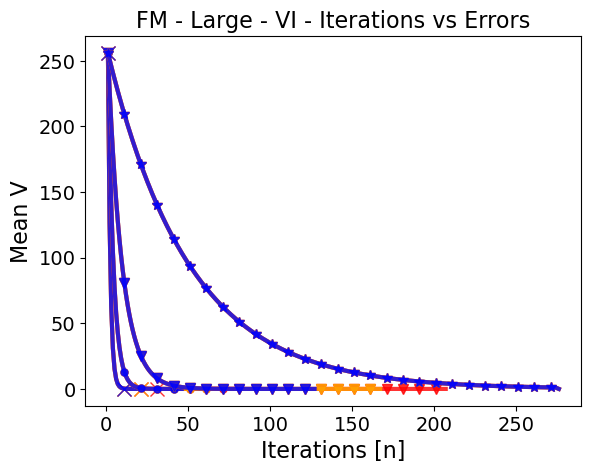

In [88]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7', markevery=10)
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5', markevery=10)
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3', markevery=10)

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7', markevery=10)
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5', markevery=10)
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3', markevery=10)

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7', markevery=10)
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5', markevery=10)
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3', markevery=10)

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7', markevery=10)
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5', markevery=10)
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3', markevery=10)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Large - VI - Iterations vs Errors', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
#plt.xscale('log')

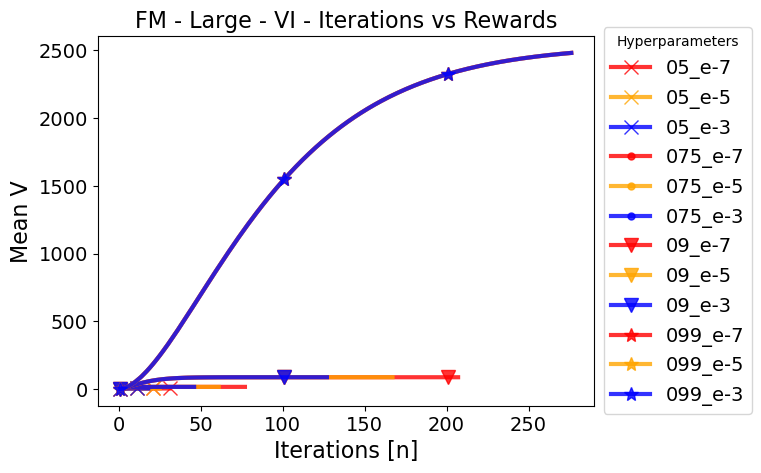

In [84]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=100)
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=100)
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=100)

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=100)
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=100)
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=100)

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=100)
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=100)
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=100)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Large - VI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})

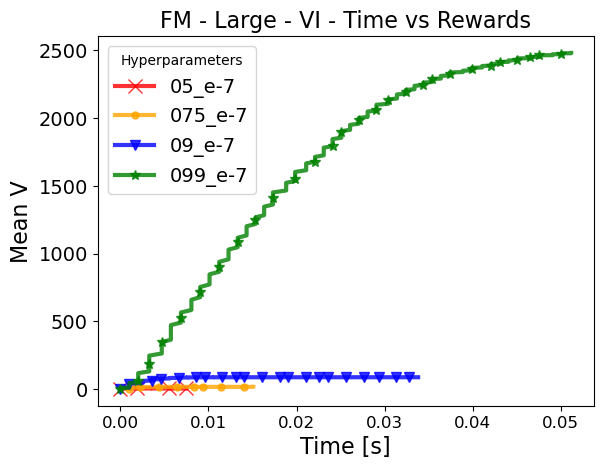

In [89]:
plt.plot(vi_df_05_e7['Time'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
#plt.plot(vi_df_05_e5['Time'],vi_df_05_e5['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'firebrick', label='05_e-5')
#plt.plot(vi_df_05_e3['Time'],vi_df_05_e3['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'lightcoral', label='05_e-3')

plt.plot(vi_df_075_e7['Time'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7',markevery=10)
#plt.plot(vi_df_075_e5['Time'],vi_df_075_e5['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'bisque', label='075_e-5')
#plt.plot(vi_df_075_e3['Time'],vi_df_075_e3['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'peru', label='075_e-3')

plt.plot(vi_df_09_e7['Time'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7',markevery=10)
#plt.plot(vi_df_09_e5['Time'],vi_df_09_e5['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'navy', label='09_e-5')
#plt.plot(vi_df_09_e3['Time'],vi_df_09_e3['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'cyan', label='09_e-3')

plt.plot(vi_df_099_e7['Time'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7',markevery=10)
#plt.plot(vi_df_099_e5['Time'],vi_df_099_e5['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lightgreen', label='099_e-5')
#plt.plot(vi_df_099_e3['Time'],vi_df_099_e3['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lawngreen', label='099_e-3')


plt.xlabel("Time [s]",fontsize = 16)

plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FM - Large - VI - Time vs Rewards', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 



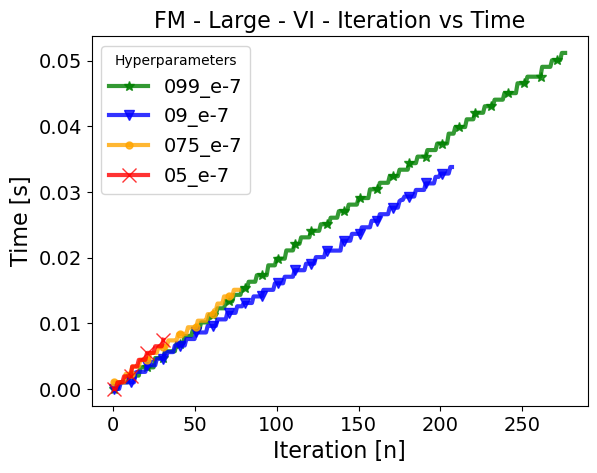

In [91]:
plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7',markevery=10)
plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7',markevery=10)
plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7',markevery=10)
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)

plt.xlabel("Iteration [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Large - VI - Iteration vs Time', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

In [81]:
vi_df

,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-03,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",19,0.004986,990.104006,"(0.6622049357233099, 1.3311023108347446, 1.331..."
1,1.000000e-05,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",26,0.005190,990.105555,"(0.6622073468516041, 1.3311036602465625, 1.331..."
2,1.000000e-07,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",32,0.005931,990.105566,"(0.6622073576840415, 1.3311036786413675, 1.331..."
3,1.000000e-03,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,0.007750,1941.796009,"(1.7044458066770525, 2.2783335418368544, 2.278..."
4,1.000000e-05,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",64,0.012214,1941.797207,"(1.7044476141458536, 2.2783357029242577, 2.278..."
5,1.000000e-07,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",79,0.014502,1941.797217,"(1.7044476324258802, 2.278335724282957, 2.2783..."
6,1.000000e-03,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",133,0.023108,4587.544018,"(4.711788562011148, 5.240609405820053, 5.24060..."
7,1.000000e-05,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",173,0.027363,4587.545001,"(4.711792641354771, 5.240613372254971, 5.24061..."
8,1.000000e-07,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",213,0.034352,4587.545010,"(4.711792701376236, 5.240613431159993, 5.24061..."
9,1.000000e-03,0.99,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",266,0.058574,25027.277577,"(50.951624172737276, 53.98306335634563, 57.076..."


In [75]:
%%time
applied_df_full =pd.DataFrame()
for i in range(0,5):
    print(i)
    applied_df = vi_df.apply(lambda x: evaluate_policy(T,R, x["Policy"]), axis =1)
    applied_df = applied_df.to_frame()
    applied_df = applied_df.rename(columns = {0:'Score_'+str(i)})
    applied_df['Epsilon'] = vi_df['Epsilon']
    applied_df['Discount'] = vi_df['Discount']
    applied_df_full = pd.concat([applied_df_full,applied_df], axis =1)

0
1
2
3
4
Wall time: 49min


In [76]:
applied_df_full = applied_df_full.loc[:,~applied_df_full.columns.duplicated()].copy()
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4
0,4858.959575,1.000000e-03,0.50,5013.447087,4907.630731,4777.565236,4793.381131
1,4987.193285,1.000000e-05,0.50,4814.782769,4817.611477,4878.759412,4841.973019
2,4940.276539,1.000000e-07,0.50,4710.961139,4702.806990,4832.616463,4836.099050
3,4808.557724,1.000000e-03,0.75,4901.877440,4851.885050,4783.308755,4885.251373
4,4747.735975,1.000000e-05,0.75,4923.913090,4768.232551,4656.365926,4669.914710
5,4810.704083,1.000000e-07,0.75,4869.001484,4819.068764,4874.800068,4782.304050
6,4686.653438,1.000000e-03,0.90,4747.732666,4640.742359,4743.796549,4732.184199
7,4655.968338,1.000000e-05,0.90,4831.555312,4890.232966,4718.429929,4781.532893
8,4572.509978,1.000000e-07,0.90,4749.317454,4931.874631,4846.984636,4928.991284
9,4501.272630,1.000000e-03,0.99,4592.710615,4578.678660,4561.240048,4542.087396


In [77]:
applied_df_full['Score_Mean'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].mean(axis = 1)
applied_df_full['Score_Std'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].std(axis = 1)

In [78]:
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4,Score_Mean,Score_Std
0,4858.959575,1.000000e-03,0.50,5013.447087,4907.630731,4777.565236,4793.381131,4870.196752,95.563425
1,4987.193285,1.000000e-05,0.50,4814.782769,4817.611477,4878.759412,4841.973019,4868.063992,71.363969
2,4940.276539,1.000000e-07,0.50,4710.961139,4702.806990,4832.616463,4836.099050,4804.552036,99.140402
3,4808.557724,1.000000e-03,0.75,4901.877440,4851.885050,4783.308755,4885.251373,4846.176068,50.073830
4,4747.735975,1.000000e-05,0.75,4923.913090,4768.232551,4656.365926,4669.914710,4753.232450,106.901899
5,4810.704083,1.000000e-07,0.75,4869.001484,4819.068764,4874.800068,4782.304050,4831.175690,39.648388
6,4686.653438,1.000000e-03,0.90,4747.732666,4640.742359,4743.796549,4732.184199,4710.221842,45.824492
7,4655.968338,1.000000e-05,0.90,4831.555312,4890.232966,4718.429929,4781.532893,4775.543887,92.042176
8,4572.509978,1.000000e-07,0.90,4749.317454,4931.874631,4846.984636,4928.991284,4805.935597,150.317580
9,4501.272630,1.000000e-03,0.99,4592.710615,4578.678660,4561.240048,4542.087396,4555.197870,35.619087


In [79]:
a1 = applied_df_full[applied_df_full['Epsilon']==1.e-07]
a2 = applied_df_full[applied_df_full['Epsilon']==1.e-05]
a3 = applied_df_full[applied_df_full['Epsilon']==1.e-03]

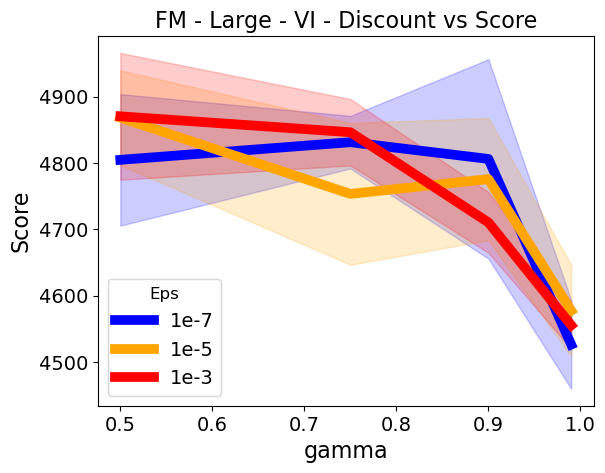

In [80]:
plt.plot(a1['Discount'],a1['Score_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Score_Mean']+a1['Score_Std'],a1['Score_Mean']-a1['Score_Std'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Score_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Score_Mean']+a2['Score_Std'],a2['Score_Mean']-a2['Score_Std'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Score_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Score_Mean']+a3['Score_Std'],a3['Score_Mean']-a3['Score_Std'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Large - VI - Discount vs Score', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

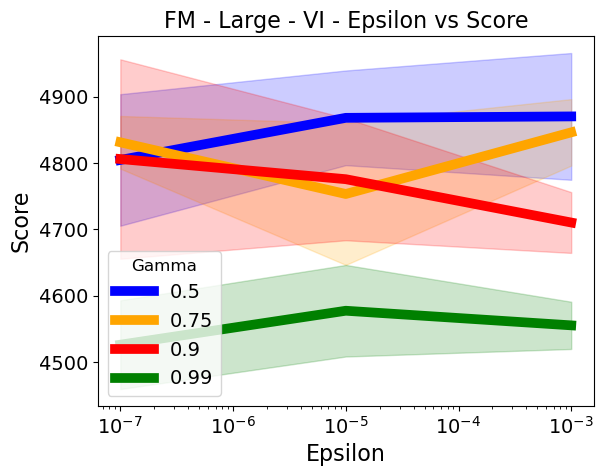

In [83]:
b1 = applied_df_full[applied_df_full['Discount']==0.5]
b2 = applied_df_full[applied_df_full['Discount']==0.75]
b3 = applied_df_full[applied_df_full['Discount']==0.9]
b4 = applied_df_full[applied_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Score_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Score_Mean']+b1['Score_Std'],b1['Score_Mean']-b1['Score_Std'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Score_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Score_Mean']+b2['Score_Std'],b2['Score_Mean']-b2['Score_Std'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Score_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Score_Mean']+b3['Score_Std'],b3['Score_Mean']-b3['Score_Std'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Score_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Score_Mean']+b4['Score_Std'],b4['Score_Mean']-b4['Score_Std'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Large - VI - Epsilon vs Score', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

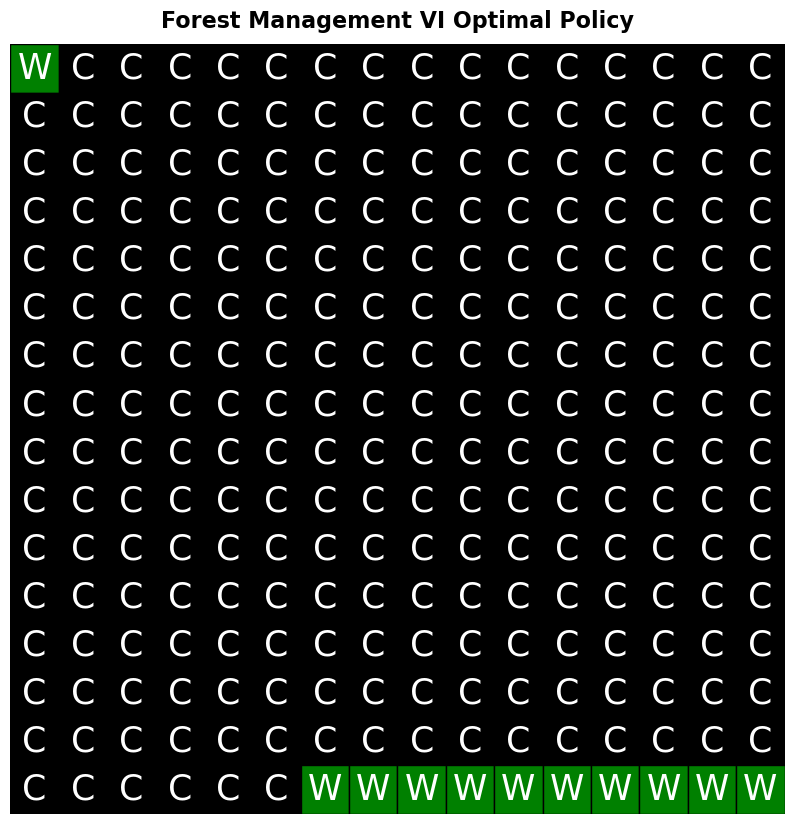

In [94]:
bestPolicy =  vi_df.loc[2]['Policy']

title='Forest Management VI Optimal Policy'
plot_forest(bestPolicy, title)